In [44]:
#Import libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import seaborn as sns
import statsmodels.api as sm

In [32]:
#load in our dataset
df = pd.read_csv("Resources/mountain_pastured_cows.csv")
display(df.head())

,newid,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,224364,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,83453,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,261565,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,122783,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,252570,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


### Data Exploration

In [33]:
#check dtypes
df.dtypes

newid               int64
lact_num            int64
calv_date          object
alp_date           object
avg_milk          float64
avg_thi3          float64
avg_csi3          float64
avg_thi30         float64
avg_csi30         float64
avg_precspring    float64
dtype: object

In [34]:
#check for nulls, negligible amount, should be clear to dropna
print(df.isna().sum()/len(df))
print(df.shape)

newid             0.00000
lact_num          0.00000
calv_date         0.00000
alp_date          0.00000
avg_milk          0.00000
avg_thi3          0.00205
avg_csi3          0.00205
avg_thi30         0.00205
avg_csi30         0.00205
avg_precspring    0.00000
dtype: float64
(20000, 10)


In [35]:
df = df.dropna()
print(df.shape)

(19959, 10)


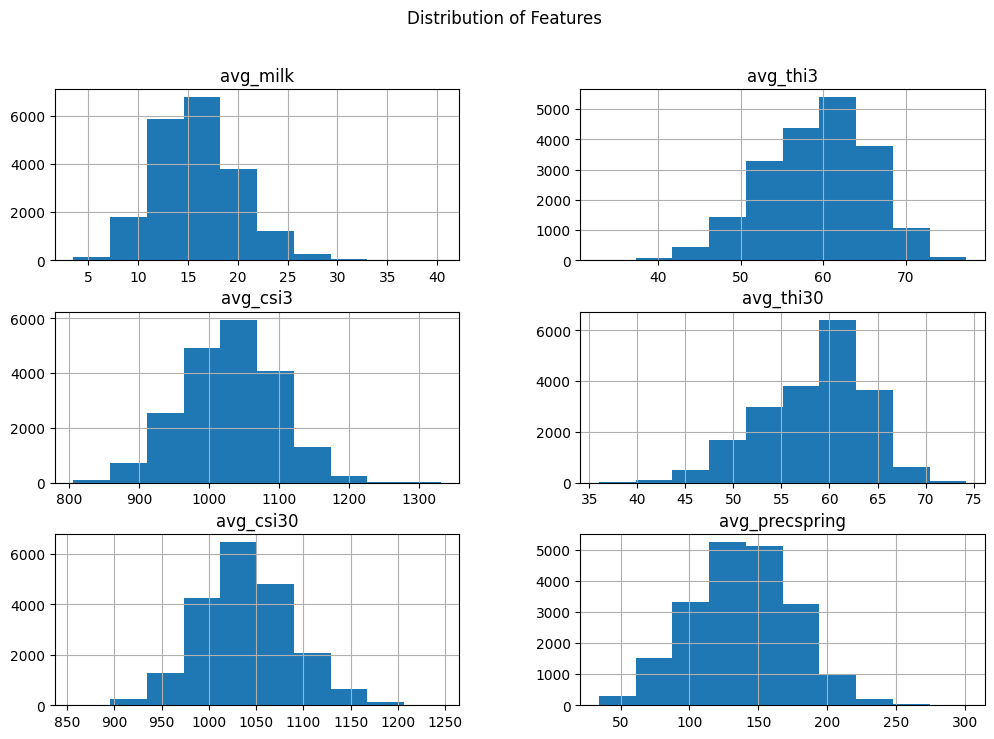

In [36]:
# Visualize distributions of numeric columns
numeric_columns = ['avg_milk', 'avg_thi3', 'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring']
df[numeric_columns].hist(figsize=(12, 8))
plt.suptitle("Distribution of Features")
plt.show()

## Preporccessing Data

### Data Leakage 

In [7]:
# remove id column
df = df.drop("newid", axis = 1)
df.head()

,lact_num,calv_date,alp_date,avg_milk,avg_thi3,avg_csi3,avg_thi30,avg_csi30,avg_precspring
0,5,2010-02-19,2010-06-05,26.20,60.17,966.13,54.81,1038.28,134.61
1,5,2001-11-09,2002-06-15,12.20,66.08,917.76,54.56,1111.54,184.40
2,3,2000-09-16,2001-06-24,14.60,66.78,899.06,61.77,1000.32,184.08
3,5,2008-10-18,2009-06-29,15.17,63.49,1053.80,62.35,1037.26,116.96
4,1,2007-09-14,2008-06-02,12.03,65.96,969.90,61.04,998.60,154.72


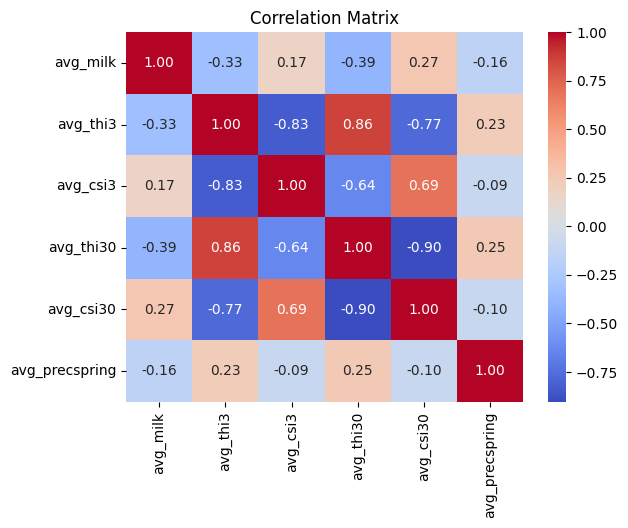

In [38]:
corr_matrix = df[numeric_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [51]:
#features = ['newid', 'lact_num', 'avg_milk', 'avg_thi3', 'avg_csi3', 'avg_thi30', 'avg_csi30', 'avg_precspring']
features = ['newid', 'lact_num', 'avg_milk', 'avg_thi3', 'avg_csi3', 'avg_csi30', 'avg_precspring']

# Calculate VIF
X = df[features]
X = sm.add_constant(X)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [vif(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          Feature          VIF
0           const  3832.627161
1           newid     1.109790
2        lact_num     1.142015
3        avg_milk     1.280419
4        avg_thi3     5.166333
5        avg_csi3     3.607768
6       avg_csi30     2.587634
7  avg_precspring     1.122540
